# Agent Langgraph
## Z narzędziami

## Importowanie bibliotek

In [21]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
import logging
from IPython.display import Image, Markdown, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from swc_toolkit import SportWorldCentralToolkit
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Literal

## Konfiguracja logowania

In [22]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    logging.basicConfig(
        filename="langgraph_notebook.log",
        level=logging.INFO
    )

## Tworzenie zestawu narzędzi

In [23]:
swc_toolkit = SportWorldCentralToolkit()
tools = swc_toolkit.get_tools()

## Konfiguracja agenta i modelu

In [24]:
tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4.1-nano", temperature =0).bind_tools(tools)

def should_continue(state: MessagesState) -> Literal['tools', END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", 'agent')

checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)

## Wizualizacja grafu

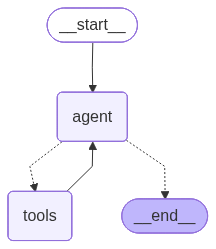

In [25]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Czat z agentem

In [26]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="W jakich zespołach grał Joe Montana?")]},
    config={"configurable": {"thread_id":99}}
)
display(Markdown(final_state["messages"][-1].content))

Nie udało się znaleźć informacji o zespołach, w których grał Joe Montana. Czy chcesz, abym spróbował znaleźć informacje o jego karierze w NFL?

In [29]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="wymień 2 najlepszych zawodników z każdej ligii")]},
    config={"configurable": {"thread_id":99}}
)
display(Markdown(final_state["messages"][-1].content))

Oto dwóch najlepszych zawodników z każdej ligi:

1. Liga "Pigskin Prodigal Fantasy League":
   - Aaron Rodgers (QB)
   - Julio Jones (WR)

2. Liga "Recurring Champions League":
   - Ryan Tannehill (QB)
   - Jameis Winston (QB)

3. Liga "AHAHFZZFFFL":
   - Brak danych o zawodnikach

4. Liga "Gridiron Gurus Fantasy League":
   - Matt Barkley (QB)
   - Jimmy Garoppolo (QB)

5. Liga "Best League Ever":
   - Brak danych o zawodnikach